In [4]:
# import the libraries as shown below
import keras
import tensorflow as tf
import keras.utils
from keras import utils as np_utils
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [25]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Dataset/Train/Train_new'
valid_path = '/content/drive/MyDrive/Test_new'

# New Section

In [109]:
pip install opencv-python

In [6]:
import cv2



In [27]:
img_new = cv2.imread('/content/drive/MyDrive/Test images/justin.jpg')
img_new.shape

(1798, 1800, 3)

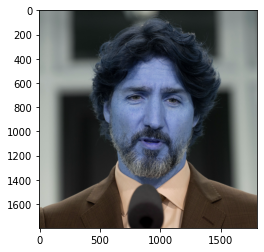

In [28]:
plt.imshow(img_new)


In [29]:
gray = cv2.cvtColor(img_new, cv2.COLOR_BGR2GRAY)
gray.shape

(1798, 1800)

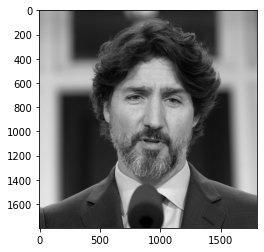

In [30]:
plt.imshow(gray, cmap='gray')


In [31]:

face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Haarcascades/haarcascade_eye.xml')

In [32]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[558, 422, 791, 791]], dtype=int32)

In [33]:
(x,y,w,h) = faces[0]
x,y,w,h

(558, 422, 791, 791)

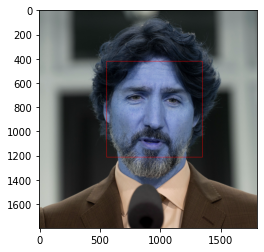

In [34]:
face_img = cv2.rectangle(img_new,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

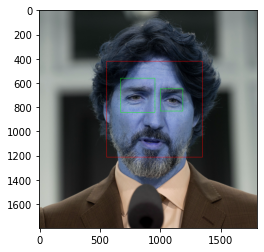

In [68]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img_new,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

In [135]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [136]:
path_to_data = "/content/drive/MyDrive/Dataset/Train"
path_to_cr_data = "/content/drive/MyDrive/Dataset/Train/cropped"

In [137]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [138]:
img_dirs

['/content/drive/MyDrive/Dataset/Train/Blanchet_ Yves-François - Google Search',
 '/content/drive/MyDrive/Dataset/Train/Paul_ Annamie - Google Search',
 '/content/drive/MyDrive/Dataset/Train/Singh_ Jagmeet - Google Search',
 '/content/drive/MyDrive/Dataset/Train/O_Toole_ Erin - Google Search',
 '/content/drive/MyDrive/Dataset/Train/justin trudeau - Google Search',
 '/content/drive/MyDrive/Dataset/Train/cropped']

In [140]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [141]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1    

Blanchet_ Yves-François - Google Search
Generating cropped images in folder:  /content/drive/MyDrive/Dataset/Train/croppedBlanchet_ Yves-François - Google Search
Paul_ Annamie - Google Search
Generating cropped images in folder:  /content/drive/MyDrive/Dataset/Train/croppedPaul_ Annamie - Google Search
Singh_ Jagmeet - Google Search
Generating cropped images in folder:  /content/drive/MyDrive/Dataset/Train/croppedSingh_ Jagmeet - Google Search
O_Toole_ Erin - Google Search
Generating cropped images in folder:  /content/drive/MyDrive/Dataset/Train/croppedO_Toole_ Erin - Google Search
justin trudeau - Google Search
Generating cropped images in folder:  /content/drive/MyDrive/Dataset/Train/croppedjustin trudeau - Google Search
cropped


In [36]:
# Import the inception v3 library as shown below
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [37]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [38]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Dataset/Train/Train_new/*')

In [39]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [40]:
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [41]:
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [42]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [43]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [44]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Dataset/Train/Train_new',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 431 images belonging to 5 classes.


In [192]:
training_set.class_indices

{'Blanchet': 0,
 'O_Toole_ Erin': 1,
 'Paul_ Annamie': 2,
 'Singh_ Jagmeet': 3,
 'justin trudeau': 4}

In [45]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Test_new',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 66 images belonging to 5 classes.


In [72]:
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())  

In [77]:
  import sklearn.metrics as metrics

true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())  
report = metrics.classification_report(true_classes, y_pred, target_names=class_labels)
print(report) 


                                          precision    recall  f1-score   support

Blanchet_ Yves-François - Google Search       0.36      0.29      0.32        14
           O_Toole_ Erin - Google Search       0.29      0.31      0.30        13
           Paul_ Annamie - Google Search       0.31      0.33      0.32        15
          Singh_ Jagmeet - Google Search       0.17      0.17      0.17        12
          justin trudeau - Google Search       0.23      0.25      0.24        12

                                accuracy                           0.27        66
                               macro avg       0.27      0.27      0.27        66
                            weighted avg       0.28      0.27      0.27        66



In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)

In [46]:
# fit the model
# Run the cell. It will take some time to execute

r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[early_stop])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/10
27/27 [==============================] - 153s 6s/step - loss: 9.5529 - accuracy: 0.4571 - val_loss: 1.8230 - val_accuracy: 0.8333
Epoch 2/10
27/27 [==============================] - 67s 2s/step - loss: 1.4246 - accuracy: 0.7889 - val_loss: 0.3635 - val_accuracy: 0.8636
Epoch 3/10
27/27 [==============================] - 67s 2s/step - loss: 0.6850 - accuracy: 0.8817 - val_loss: 0.5790 - val_accuracy: 0.8788
Epoch 4/10
27/27 [==============================] - 65s 2s/step - loss: 0.4766 - accuracy: 0.8910 - val_loss: 1.1138 - val_accuracy: 0.7727
Epoch 5/10
27/27 [==============================] - 66s 2s/step - loss: 0.7941 - accuracy: 0.8747 - val_loss: 0.4141 - val_accuracy: 0.9091
Epoch 6/10
27/27 [==============================] - 66s 2s/step - loss: 0.5188 - accuracy: 0.9165 - val_loss: 0.1552 - val_accuracy: 0.9242
Epoch 7/10
27/27 [==============================] - 67s 2s/step - loss: 0.4174 - accuracy: 0.9118 - val_loss: 0.1511 - val_accuracy: 0.9697
Epoch 8/10
27/27 [=

In [47]:
model.evaluate(test_set)


5/5 [==============================] - 9s 1s/step - loss: 0.1223 - accuracy: 0.9697


[0.12229494750499725, 0.9696969985961914]

In [48]:
import matplotlib.pyplot as plt


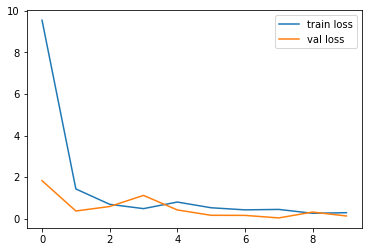

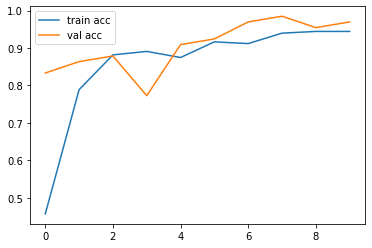

<Figure size 432x288 with 0 Axes>

In [49]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [50]:


from tensorflow.keras.models import load_model

model.save('model_inception_final_model.h5')

In [51]:
y_pred = model.predict(test_set)

In [52]:
y_pred

array([[1.62296947e-13, 1.91012589e-07, 6.27634012e-13, 2.28995452e-13,
        9.99999762e-01],
       [3.47927902e-32, 9.17437102e-18, 1.00000000e+00, 7.53860396e-33,
        9.28101247e-29],
       [1.14253641e-16, 2.87638349e-15, 1.00000000e+00, 3.09035345e-28,
        8.52019089e-19],
       [3.15074584e-17, 1.27810197e-12, 3.64108015e-11, 2.00093168e-19,
        1.00000000e+00],
       [3.81497185e-20, 4.18431523e-15, 1.00000000e+00, 2.22737095e-25,
        9.17021962e-23],
       [0.00000000e+00, 2.11464306e-30, 5.41866103e-32, 1.00000000e+00,
        0.00000000e+00],
       [8.50790326e-29, 1.69731255e-28, 1.00000000e+00, 6.19308240e-30,
        3.66024966e-37],
       [1.00000000e+00, 1.55364957e-12, 6.40126521e-21, 4.25233439e-22,
        2.44685772e-10],
       [7.07593452e-15, 9.46480186e-11, 8.39006424e-01, 3.85681821e-22,
        1.60993546e-01],
       [9.45344594e-31, 1.08703733e-19, 1.00000000e+00, 4.50747578e-30,
        2.19951130e-29],
       [1.07357158e-16, 1.6223

In [53]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [54]:
y_pred

array([4, 2, 2, 4, 2, 3, 2, 0, 2, 2, 2, 0, 0, 3, 0, 0, 1, 3, 0, 4, 1, 3,
       0, 2, 2, 4, 1, 1, 0, 1, 4, 3, 3, 2, 1, 4, 3, 2, 3, 0, 1, 2, 0, 0,
       3, 3, 4, 1, 3, 1, 2, 1, 3, 4, 2, 2, 0, 4, 2, 0, 4, 2, 1, 0, 4, 1])

In [55]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [56]:
model=load_model('model_inception_final_model.h5')

In [57]:
img=image.load_img('/content/drive/MyDrive/Dataset/Test/O_Toole_ Erin - Google Search/6 Reasons Why Erin O_Toole Wants You To....jpg',target_size=(224,224))


In [58]:
x=image.img_to_array(img)
x

array([[[ 45., 107., 182.],
        [ 45., 107., 182.],
        [ 45., 107., 182.],
        ...,
        [ 29.,  80., 145.],
        [ 29.,  80., 145.],
        [ 29.,  80., 145.]],

       [[ 45., 107., 182.],
        [ 45., 107., 182.],
        [ 45., 107., 182.],
        ...,
        [ 29.,  80., 145.],
        [ 29.,  80., 145.],
        [ 29.,  80., 145.]],

       [[ 45., 107., 182.],
        [ 45., 107., 182.],
        [ 45., 107., 182.],
        ...,
        [ 29.,  80., 145.],
        [ 29.,  80., 145.],
        [ 29.,  80., 145.]],

       ...,

       [[ 41.,  98., 165.],
        [ 42., 108., 182.],
        [ 44., 108., 182.],
        ...,
        [ 29.,  80., 146.],
        [ 29.,  80., 145.],
        [ 29.,  80., 145.]],

       [[ 49., 108., 178.],
        [ 42., 108., 184.],
        [ 45., 107., 180.],
        ...,
        [ 29.,  80., 145.],
        [ 29.,  80., 143.],
        [ 29.,  80., 143.]],

       [[ 48., 106., 180.],
        [ 42., 108., 186.],
        [ 47., 1

In [59]:
x.shape


(224, 224, 3)

In [60]:
x=x/255

In [61]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [62]:
model.predict(img_data)


array([[4.8248149e-03, 3.5580212e-01, 6.2272489e-01, 3.5348869e-04,
        1.6294681e-02]], dtype=float32)

In [63]:
a=np.argmax(model.predict(img_data), axis=1)


In [64]:
a==2

array([ True])

In [78]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
y_pred_new = model.predict(test_set)

y_pred_classes= [np.argmax(element) for element in y_pred_new]

#print("classification report:\n", classification_report(test_set, y_pred_classes))

In [ ]:
import sklearn.metrics as metrics

true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())  
report = metrics.classification_report(true_classes, y_pred, target_names=class_labels)
print(report) 


In [66]:
img_nw=image.load_img('/content/drive/MyDrive/Test_new/O_Toole_ Erin - Google Search/Erin O_Toole speaks out against the....jpg',target_size=(224,224))
i= image.img_to_array(img)
i= preprocess_input(i)
input_arr = np.array([i])
input_arr.shape
pred= np.argmax(model.predict(input_arr))

if pred==0:
  print("Blanchet")
elif pred==1:
  print("O_toole_erin")
elif pred==2:
  print("paul_ annamie")
elif pred==3:
  print("Singh_Jagmeet")
elif pred==4:
  print("Justin_Trudeau")
else:
  print("No image")

O_toole_erin


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


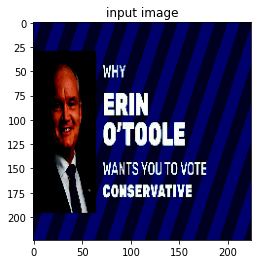

In [67]:
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

In [176]:
import os


In [ ]:
dir_path = '/content/drive/MyDrive/Test images'

for i in os.listdir(dir_path):
  img =image.load_img(dir_path+'//'+ i, target_size=(224,224))
  plt.imshow(img)
  plt.show()
  S= image.img_to_array(img)
  S= np.expand_dims(S, axis=0)
  images = np.vstack([S])
  pred = np.argmax(model.predict(images))
  if pred==0:
       print("Blanchet")
  elif pred==1:
       print("O_toole_erin")
  elif pred==2:
       print("paul_ annamie")
  elif pred==3:
       print("Singh_Jagmeet")
  elif pred==4:
       print("Justin_Trudeau")
  else:
       print("No image")
 
